# BBC 뉴스 public dataset으로 categorizer 만들기

* 아래의 kaggle을 그대로 따라감
* https://www.kaggle.com/bbose71/bbc-news-classification

In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import display
from pathlib import Path
from smart_open import open
from gensim.utils import simple_preprocess
from tqdm.auto import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib

import seaborn as sns

%matplotlib inline

In [2]:
data = []
for cat in tqdm(os.listdir('bbc')):
    for fname in glob.glob('bbc/' + cat + '/*.txt'):
        file = Path(fname)
        iid = cat + '-' + file.name.split('.')[0]
        try:
            txt = file.read_text(encoding='latin-1')
        except:
            print(iid)
        data.append([iid, txt, cat])
        
df = pd.DataFrame(data, columns=['ArticleId', 'Text', 'Category']); df

,ArticleId,Text,Category
0,business-001,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,business-002,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,business-003,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,business-004,High fuel prices hit BA's profits\n\nBritish A...,business
4,business-005,Pernod takeover talk lifts Domecq\n\nShares in...,business
5,business-006,Japan narrowly escapes recession\n\nJapan's ec...,business
6,business-007,Jobs growth still slow in the US\n\nThe US cre...,business
7,business-008,"India calls for fair trade rules\n\nIndia, whi...",business
8,business-009,Ethiopia's crop production up 24%\n\nEthiopia ...,business
9,business-010,Court rejects $280bn tobacco case\n\nA US gove...,business


In [3]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id'); category_id_df

,Category,category_id
0,business,0
510,entertainment,1
896,politics,2
1313,sport,3
1824,tech,4


In [4]:
category_to_id = dict(category_id_df.values); category_to_id

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [5]:
id_to_category = dict(category_id_df[['category_id', 'Category']].values); id_to_category

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [6]:
df.sample(5, random_state=0)

,ArticleId,Text,Category,category_id
384,business-385,Tate & Lyle boss bags top award\n\nTate & Lyle...,business,0
1983,tech-160,Halo 2 sells five million copies\n\nMicrosoft ...,tech,4
985,politics-090,MSPs hear renewed climate warning\n\nClimate c...,politics,2
1386,sport-074,Pavey focuses on indoor success\n\nJo Pavey wi...,sport,3
1294,politics-399,Tories reject rethink on axed MP\n\nSacked MP ...,politics,2


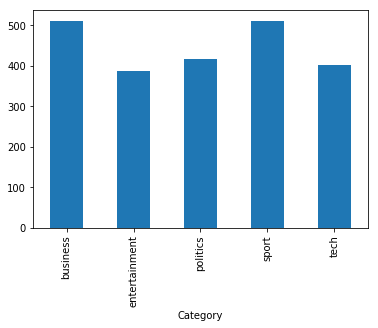

In [7]:
df.groupby('Category').category_id.count().plot.bar(ylim=0)

In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.Text).toarray()
labels = df.category_id; features.shape

(2225, 14415)

In [9]:
N = 3

for Category, category_id in tqdm(sorted(category_to_id.items())):
    features_chi2 = chi2(features, labels==category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' '))==1]
    bigrams = [v for v in feature_names if len(v.split(' '))==2]
    print('# {}'.format(Category))
    print('  .Most correlated unigrams:\n    .{}'.format('\n    .'.join(unigrams[-N:])))
    print('  .Most correlated bigrams:\n    .{}'.format('\n    .'.join(bigrams[-N:])))

# business
  .Most correlated unigrams:
    .oil
    .growth
    .shares
  .Most correlated bigrams:
    .analysts said
    .economic growth
    .stock market
# entertainment
  .Most correlated unigrams:
    .singer
    .actor
    .film
  .Most correlated bigrams:
    .los angeles
    .film festival
    .box office
# politics
  .Most correlated unigrams:
    .blair
    .election
    .labour
  .Most correlated bigrams:
    .prime minister
    .tony blair
    .mr blair
# sport
  .Most correlated unigrams:
    .coach
    .match
    .cup
  .Most correlated bigrams:
    .grand slam
    .australian open
    .champions league
# tech
  .Most correlated unigrams:
    .technology
    .software
    .users
  .Most correlated bigrams:
    .anti virus
    .mobile phones
    .mobile phone



In [10]:
SAMPLE_SIZE = int(len(features)*0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]); projected_features.shape

(667, 2)

In [11]:
category_id_test = 0
projected_features[labels[indices]==category_id_test]

array([[ 20.867317 , -24.286161 ],
       [ 32.15504  , -34.496788 ],
       [ 21.945278 , -28.672266 ],
       [ 10.729226 , -22.20582  ],
       [-15.323385 , -11.129261 ],
       [ 13.543248 , -35.330227 ],
       [ 13.5722475, -16.537634 ],
       [ 30.31591  , -27.98926  ],
       [ 38.132023 , -23.728315 ],
       [ 10.157736 , -33.80925  ],
       [ 26.371328 , -37.92122  ],
       [ 15.23539  , -34.75432  ],
       [ 15.68058  , -32.66936  ],
       [ 16.843668 , -22.685152 ],
       [ 17.596556 , -28.77592  ],
       [  7.954508 ,  -9.466415 ],
       [ 25.484049 , -18.129175 ],
       [  9.885706 , -13.634229 ],
       [  6.8335476, -12.146235 ],
       [ -1.2814156,  -6.5572157],
       [  4.393556 , -18.388744 ],
       [ 24.894709 , -37.420197 ],
       [ 26.115585 , -38.80898  ],
       [ 25.866795 , -41.043808 ],
       [ 12.362574 , -22.257097 ],
       [ 26.460035 , -41.3697   ],
       [ 21.773987 , -20.330444 ],
       [ 11.0408125,  -9.513612 ],
       [ 24.104187 ,

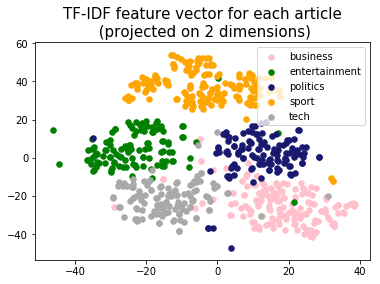

In [12]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

for category, category_id in sorted(category_to_id.items()):
    points = projected_features[labels[indices]==category_id]
    plt.scatter(points[:,0], points[:,1], s=30, c=colors[category_id], label=category)
    
plt.title('TF-IDF feature vector for each article\n (projected on 2 dimensions)', fontdict=dict(fontsize=15))
plt.legend();

In [20]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), 
    MultinomialNB(), 
    #SVC(kernel='rbf', probability=True, gamma='auto', C=5), 
    SGDClassifier(random_state=0, max_iter=200, tol=1e-3, loss='log'),  
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
]

In [21]:
CV = 5
shufflesplit = ShuffleSplit(n_splits=CV, test_size=0.2, random_state=0)
entries = []

for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=shufflesplit)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [22]:
cv_df = pd.DataFrame(entries, index=range(CV*len(models)), columns=['model_name', 'fold_idx', 'accuracy']); cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.851685
1,RandomForestClassifier,1,0.820225
2,RandomForestClassifier,2,0.811236
3,RandomForestClassifier,3,0.784270
4,RandomForestClassifier,4,0.782022
5,MultinomialNB,0,0.966292
6,MultinomialNB,1,0.970787
7,MultinomialNB,2,0.968539
8,MultinomialNB,3,0.966292
9,MultinomialNB,4,0.982022


In [23]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.980225
MultinomialNB             0.970787
RandomForestClassifier    0.809888
SGDClassifier             0.984270
Name: accuracy, dtype: float64

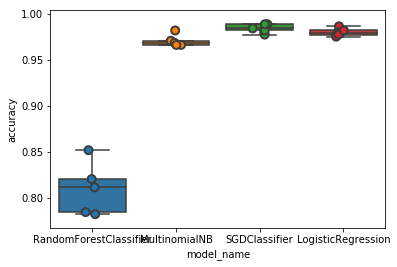

In [24]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)

In [25]:
# model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
model = SGDClassifier(random_state=0, max_iter=200, tol=1e-3, loss='log')
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1490, 14415), (735, 14415), (1490,), (735,))

In [27]:
y_pred_proba

array([[0.85507224, 0.06002785, 0.04140474, 0.03028417, 0.013211  ],
       [0.02567501, 0.01903867, 0.0173568 , 0.06357305, 0.87435647],
       [0.12692904, 0.039602  , 0.67521248, 0.05561564, 0.10264083],
       ...,
       [0.00740083, 0.01271741, 0.03519055, 0.93292575, 0.01176546],
       [0.0276684 , 0.86986576, 0.02616197, 0.02630354, 0.05000032],
       [0.05058404, 0.42431025, 0.35027149, 0.04320645, 0.13162778]])

In [28]:
conf_mat = confusion_matrix(y_test, y_pred); conf_mat

array([[163,   0,   5,   0,   5],
       [  0, 120,   3,   0,   0],
       [  0,   0, 140,   0,   0],
       [  1,   0,   0, 172,   0],
       [  4,   0,   0,   0, 122]], dtype=int64)

Text(0.5, 15.0, 'Predicted')

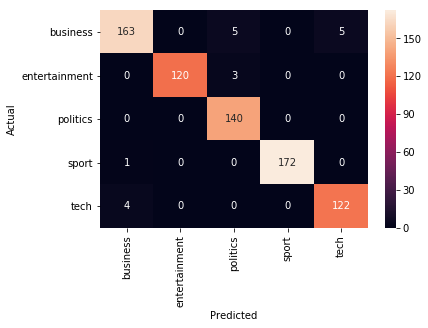

In [29]:
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [30]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print('{} predicted as {}: {} examples'.format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test==actual) & (y_pred==predicted)]]['Text'])

tech predicted as business: 4 examples


1955    US duo in first spam conviction\n\nA brother a...
1942    Argonaut founder rebuilds empire\n\nJez San, t...
1999    US duo in first spam conviction\n\nA brother a...
1937    Games maker fights for survival\n\nOne of Brit...
Name: Text, dtype: object

business predicted as politics: 5 examples


132    Salary scandal in Cameroon\n\nCameroon says wi...
503    Aids and climate top Davos agenda\n\nClimate c...
254    Call to overhaul UK state pension\n\nThe UK pe...
486    World leaders gather to face uncertainty\n\nMo...
240    G7 backs Africa debt relief plan\n\nG7 finance...
Name: Text, dtype: object

entertainment predicted as politics: 3 examples


722    TV show unites Angolan families\n\nAngolan fam...
713    No charges against TV's Cosby\n\nUS comedian B...
711    BBC 'should allow more scrutiny'\n\nMPs have u...
Name: Text, dtype: object

business predicted as tech: 5 examples


446    News Corp eyes video games market\n\nNews Corp...
251    BT offers equal access to rivals\n\nBT has mov...
253    News Corp eyes video games market\n\nNews Corp...
19     Call centre users 'lose patience'\n\nCustomers...
204    Orange colour clash set for court\n\nA row ove...
Name: Text, dtype: object

In [31]:
model.fit(features, labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=200,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
N = 3

for Category, category_id in tqdm(sorted(category_to_id.items())):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' '))==1]
    bigrams = [v for v in feature_names if len(v.split(' '))==2]
    print('# {}'.format(Category))
    print('  .Most correlated unigrams:\n    .{}'.format('\n    .'.join(unigrams[-N:])))
    print('  .Most correlated bigrams:\n    .{}'.format('\n    .'.join(bigrams[-N:])))

# business
  .Most correlated unigrams:
    .shares
    .company
    .bank
  .Most correlated bigrams:
    .analysts said
    .stock market
    .chief executive
# entertainment
  .Most correlated unigrams:
    .singer
    .music
    .film
  .Most correlated bigrams:
    .new york
    .los angeles
    .box office
# politics
  .Most correlated unigrams:
    .mr
    .labour
    .party
  .Most correlated bigrams:
    .mr brown
    .tony blair
    .mr blair
# sport
  .Most correlated unigrams:
    .cup
    .club
    .match
  .Most correlated bigrams:
    .world number
    .australian open
    .year old
# tech
  .Most correlated unigrams:
    .online
    .technology
    .computer
  .Most correlated bigrams:
    .bbc news
    .news website
    .said mr



In [34]:
fnames_test = glob.glob('newsdata/downloaded/*.json')[-20:]

test_data = []
for fname in fnames_test:
    with open(fname, encoding='UTF-8-sig') as f:
        content = json.load(f)
        test_data.append(content['text'])

In [77]:
fnames_test

['newsdata/downloaded\\fff85be9c45b8ddb7c746606b73ef12b084c2982.json',
 'newsdata/downloaded\\fff86c8f4c13200d83172abe686cd814c4676d57.json',
 'newsdata/downloaded\\fff8d897938565b3991237c1dbe046e1d40ae46c.json',
 'newsdata/downloaded\\fff98bafbd5e81d192f0df607d4854ad5f4f9601.json',
 'newsdata/downloaded\\fffa26bf3775b1f0cd241e37a8ce4d52eef9020f.json',
 'newsdata/downloaded\\fffaad96cdd3ea1a5c68b634f5dd3e6720cee373.json',
 'newsdata/downloaded\\fffac47b6906a4cf22b747ec9a66c5f76de5dcc3.json',
 'newsdata/downloaded\\fffb2181d5b5d3c72f7ae699af4b5869d3160e1c.json',
 'newsdata/downloaded\\fffb3a399e07b0ca9f168caa2d298d6c7970ebd7.json',
 'newsdata/downloaded\\fffb3ace48a67aa0dfcdcd790948cfbae6c6aff6.json',
 'newsdata/downloaded\\fffba400853301314ebcbe0a04b4e2200cbc9330.json',
 'newsdata/downloaded\\fffc4188682480a47f2eff3b2b48235cecaf1ce4.json',
 'newsdata/downloaded\\fffc8d1773289450f8973dc035127dfdcdac3a53.json',
 'newsdata/downloaded\\fffcfcad4d05790822d9998aff8e441231c6f295.json',
 'news

In [35]:
test_features = tfidf.transform(test_data)

In [36]:
Y_pred = model.predict(test_features); Y_pred

array([3, 3, 0, 3, 1, 0, 0, 1, 0, 0, 3, 0, 1, 4, 0, 0, 0, 1, 0, 1],
      dtype=int64)

In [37]:
Y_pred_proba = model.predict_proba(test_features).max(axis=1); Y_pred_proba

array([0.86890892, 0.3226563 , 0.40097805, 0.7827112 , 0.31672802,
       0.82365676, 0.5148186 , 0.31219247, 0.64308222, 0.49068525,
       0.83606755, 0.41347902, 0.53671394, 0.81560827, 0.8641951 ,
       0.53044634, 0.91604056, 0.51412635, 0.6597602 , 0.862062  ])

In [38]:
[id_to_category[cat_id] for cat_id in Y_pred]

['sport',
 'sport',
 'business',
 'sport',
 'entertainment',
 'business',
 'business',
 'entertainment',
 'business',
 'business',
 'sport',
 'business',
 'entertainment',
 'tech',
 'business',
 'business',
 'business',
 'entertainment',
 'business',
 'entertainment']

In [39]:
model.cat = id_to_category
model.tfidf = tfidf
model_name = 'categorizer.model'

In [40]:
joblib.dump(model, model_name)

['categorizer.model']

In [93]:
_model = joblib.load(model_name)
probas = _model.predict_proba(test_features).max(axis=1); probas

array([0.78341404, 0.2460706 , 0.34790858, 0.58997789, 0.23411507,
       0.62991991, 0.37239016, 0.26078785, 0.45385789, 0.35708725,
       0.6376675 , 0.33800991, 0.35245768, 0.65800726, 0.70583266,
       0.36370556, 0.84370115, 0.30627825, 0.48822476, 0.73129018])

In [95]:
[_model.cat[cat_id] for cat_id in _model.predict(test_features)]

['sport',
 'sport',
 'politics',
 'sport',
 'entertainment',
 'business',
 'business',
 'business',
 'business',
 'business',
 'sport',
 'business',
 'entertainment',
 'tech',
 'business',
 'business',
 'business',
 'entertainment',
 'business',
 'entertainment']

In [41]:
_model = joblib.load(model_name)

In [120]:
df_text = pd.DataFrame(test_data, columns=['text'])
_features = _model.tfidf.transform(df_text.text)
_proba = _model.predict_proba(_features).max(axis=1)
_pred = _model.predict(_features)
_cats = [_model.cat[cat_id] for cat_id in _pred]
df_text['category'] = _cats
df_text['category_proba'] = _proba; df_text

,text,category,category_proba
0,PHOENIX (AP) - A lineup of almost all reserves...,sport,0.783414
1,1. Stewed fruit: Put the dried fruit in a glas...,sport,0.246071
2,Dame Helena Morrissey emerged as a frontrunner...,politics,0.347909
3,Jermaine Jenas has declared the end for this T...,sport,0.589978
4,Russian President Vladimir Putin and some of h...,entertainment,0.234115
5,Commerce Secretary Wilbur Ross says liberal ne...,business,0.629920
6,Over 100 former Thomas Cook employees are prep...,business,0.372390
7,"Business Insider surveyed more than 3,000 read...",business,0.260788
8,U.S. President Donald Trump speaks at the 2019...,business,0.453858
9,Months before news of a July 25 phone call bet...,business,0.357087


In [42]:
df_text = pd.DataFrame(test_data, columns=['text'])
_features = _model.tfidf.transform(df_text.text)
_proba = _model.predict_proba(_features).max(axis=1)
_pred = _model.predict(_features)
_cats = [_model.cat[cat_id] for cat_id in _pred]
df_text['category'] = _cats
df_text['category_proba'] = _proba; df_text

,text,category,category_proba
0,PHOENIX (AP) - A lineup of almost all reserves...,sport,0.868909
1,1. Stewed fruit: Put the dried fruit in a glas...,sport,0.322656
2,Dame Helena Morrissey emerged as a frontrunner...,business,0.400978
3,Jermaine Jenas has declared the end for this T...,sport,0.782711
4,Russian President Vladimir Putin and some of h...,entertainment,0.316728
5,Commerce Secretary Wilbur Ross says liberal ne...,business,0.823657
6,Over 100 former Thomas Cook employees are prep...,business,0.514819
7,"Business Insider surveyed more than 3,000 read...",entertainment,0.312192
8,U.S. President Donald Trump speaks at the 2019...,business,0.643082
9,Months before news of a July 25 phone call bet...,business,0.490685


In [43]:
df_text.text.iloc[2]

"Dame Helena Morrissey emerged as a frontrunner for governor of the Bank of England after backing from MPs\n\nHEAVYWEIGHT backers have given a major boost to the chances of City ‘Superwoman’ Dame Helena Morrissey becoming the first female governor of the Bank of England in its 325-year history.\n\nShe emerged as a frontrunner this weekend after dramatically stepping down from her job running Legal & General’s personal investment business.\n\nIn an unusual move, MPs and former Bank officials lined up to praise the ‘fresh-thinking’ Brexiteer.\n\nIt follows The Mail on Sunday’s revelation last month that Dame Helena, 53, who earned her Superwoman nickname as a high-flying financier and mother-of-nine, had been interviewed to replace governor Mark Carney when he steps down in January.\n\nAndrew Sentance, a former member of the Bank’s rate-setting Monetary Policy Committee, called Dame Helena ‘an independent-minded and resilient person who has championed the role of women in the business wo